In [270]:
import math
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import re
import numpy as np
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
# sudo apt-get install texlive-latex-base texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra
fontsize=25

def replace_graph_names(df):
    df["Input Graph"] = df["Input Graph"].str.replace("com-", "", regex=True)\
                                    .str.replace(".gbbs.txt", "", regex=True)\
                                    .str.replace(".bin", "", regex=True)\
                                    .str.replace(".ungraph.txt", "", regex=True)\
                                    .str.replace(".graph.txt", "", regex=True)

def set_face_grid_ax_ticks(g):
    """Set fontsize for x and y axis ticks for all axes in a FacetGrid."""
    for ax in g.axes.flat:
        set_ax_ticks(ax)


def set_ax_ticks(ax):
    for l in ax.yaxis.get_ticklabels():
        l.set_fontsize(fontsize)
    for l in ax.xaxis.get_ticklabels():
        l.set_fontsize(fontsize)
        
def common_ax_style(ax):
    ax.set_xticks([1, 4, 8, 16, 30, 60])
    ax.set_xticklabels([1, 4, 8, 16, 30, "30h"])
    
    ax.set_yscale('log')
    # plt.yticks([0.03, 0.1, 0.3, 1])
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    set_ax_ticks(ax)
        
    ax.set_xlabel("Threads", fontsize = fontsize)

def plot_data(df, ax):
    sns.lineplot(data=df, x="Threads", y="Cluster Time", hue="Clusterer Name", linewidth = 3, ax = ax)
    sns.scatterplot(data=df, x="Threads", y="Cluster Time", hue="Clusterer Name", s = 30, ax = ax, legend=False)

def get_larger_handles(g, marker_size, ncol):
    g.add_legend(loc='upper center', ncol=ncol, bbox_to_anchor=(0.5, 1.15), fontsize=fontsize)
    if g._legend:
        for leg_handle in g._legend.legendHandles:
            leg_handle._sizes = [marker_size]

# Function to extract epsilon value from the config
def extract_epsilon(config):
    parts = config.split(',')
    for part in parts:
        if 'epsilon' in part:
            return part.split(':')[-1].strip()
    return None

def postpend_epsilon(df):
    df.loc[:, 'Clusterer Name'] = df.apply(lambda row: f"{row['Clusterer Name']}_{extract_epsilon(row['Config'])}", axis=1)

def add_epsilon_to_hac(df, remove_zero_eps = True):
    df_no_parhac = df[df["Clusterer Name"] != "ParHacClusterer"]
    df_parhac = df[df["Clusterer Name"] == "ParHacClusterer"]

    # split parhac to different methods for different epsilon
    postpend_epsilon(df_parhac)
    
    if remove_zero_eps:
        df_parhac = df_parhac[df_parhac["Clusterer Name"] != "ParHacClusterer_0"]

    df_new = pd.concat([df_no_parhac, df_parhac])
    
    return df_new

def remove_small_f1_methods(df):
    # filter out methods that can achieve > 0.5 * max f1 score
    graphs = df["Input Graph"].unique()
    dfs = []
    for graph in graphs:
        df_graph = df[df["Input Graph"] == graph]
        max_f1 = df_graph["fScore_mean"].max()
        print(graph, max_f1)
        df_graph_filtered = df_graph[df_graph["fScore_mean"] > 0.5 * max_f1]
        methods = df_graph_filtered["Clusterer Name"].unique()
        df_graph = df_graph[df_graph["Clusterer Name"].isin(methods)]
        dfs.append(df_graph)
    df = pd.concat(dfs)
    return df

In [263]:
def GetParetoDfs(df):
    dfs = {}

    graphs = df["Input Graph"].unique()
    for graph in graphs:
        for clusterer in clusterers:
            filtered_df = df[df["Input Graph"] == graph]
            filtered_df = filtered_df[filtered_df["Clusterer Name"] == clusterer]

            filtered_df = filtered_df.sort_values(by=["Cluster Time"])
            pareto_frontier = []
            max_score = float("-inf")

            for _, row in filtered_df.iterrows():
                score = row["fScore_mean"]
                if score > max_score:
                    max_score = score
                    pareto_frontier.append(row)

            pareto_df = pd.DataFrame(pareto_frontier)

            dfs[(graph, clusterer)] = (filtered_df, pareto_df)
    return dfs, graphs

## only leave methods that's on the overall pareto frontier
def filterMethodsOnOverallPareto(df):
    graphs = df["Input Graph"].unique()
    dfs = []
    for graph in graphs:
        filtered_df = df[df["Input Graph"] == graph]

        filtered_df = filtered_df.sort_values(by=["Cluster Time"])
        pareto_frontier = []
        max_score = float("-inf")

        for _, row in filtered_df.iterrows():
            score = row["fScore_mean"]
            if score > max_score:
                max_score = score
                pareto_frontier.append(row)

        pareto_df = pd.DataFrame(pareto_frontier)
        methods = pareto_df["Clusterer Name"].unique()
        df_graph = filtered_df[filtered_df["Clusterer Name"].isin(methods)]
        dfs.append(df_graph)
    df = pd.concat(dfs)
    return df
        

In [261]:
base_addr = "/Users/sy/Desktop/MIT/clusterer/csv/"

In [275]:
df = pd.read_csv(base_addr + "uci_results/out_uci_google_csv/stats.csv")
df2 = pd.read_csv(base_addr + "uci_results/out_uci_ours_csv/stats.csv")
df_affinity = pd.read_csv(base_addr + "uci_results/stats_affinity.csv")
df_hac = pd.read_csv(base_addr + "uci_results/stats_parhac.csv")
df_parcc = pd.read_csv(base_addr + "uci_results/stats_parcc.csv")
df_ldd = pd.read_csv(base_addr + "uci_results/stats_ldd.csv")
df_tectonic = pd.read_csv(base_addr + "uci_results/stats_tectonic.csv")
df_wcc = pd.read_csv(base_addr + "uci_results/stats_wcc.csv")



# df_kcore = pd.read_csv(base_addr + "uci_results/uci/kcore/out_kcore_uci_csv/stats.csv")
# df_ldd = pd.read_csv(base_addr + "uci_results/uci/ldd/out_ldd_uci_csv/stats.csv")
# df_lp = pd.read_csv(base_addr + "uci_results/uci/lp/out_lp_uci_csv/stats.csv")
# df_slpa = pd.read_csv(base_addr + "uci_results/uci/slpa/out_slpa_uci_csv/stats.csv")
# df_tectonic = pd.read_csv(base_addr + "uci_results/uci/tectonic/out_tectonic_uci_csv/stats.csv")
# df_wcc = pd.read_csv(base_addr + "uci_results/uci/wcc/out_wcc_uci_csv/stats.csv")
# df = pd.concat([df, df_kcore, df_ldd, df_lp, df_slpa, df_tectonic, df_wcc])
df = pd.concat([df, df2, df_affinity, df_hac, df_parcc, df_tectonic, df_wcc])

df = df.dropna(how='all')
df = df[df["Clusterer Name"] != "KCoreClusterer"]
replace_graph_names(df)
df = add_epsilon_to_hac(df)

/var/folders/y9/y8cbtjy94z91vmk_p7zfqpyw0000gn/T/ipykernel_17766/1523129332.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Clusterer Name'] = df.apply(lambda row: f"{row['Clusterer Name']}_{extract_epsilon(row['Config'])}", axis=1)


In [276]:
clusterers = df["Clusterer Name"].unique()
cmap = plt.cm.tab20

# Ensure there are enough colors for the values
assert len(clusterers) <= cmap.N, "Not enough colors in the colormap for the clusterer values"

colors = [cmap(i) for i in range(len(clusterers))]

color_map = dict(zip(clusterers, colors))

# Define a list of marker styles
marker_styles = ['o', 's', '^', 'P', 'd', 'X', 'v', '<', '>', '*', '*', '*', '*', '*', 'D']

# Ensure there are enough markers for the clusterer values
assert len(clusterers) <= len(marker_styles), "Not enough marker styles for the clusterer values"

# Create a style_map that maps each value in clusterer values to a marker style
style_map = dict(zip(clusterers, marker_styles))


In [277]:
df = remove_small_f1_methods(df)
df = filterMethodsOnOverallPareto(df)

faces 0.7031584395772039
iris 0.9048007615939072
digits 0.9575029171813206
wdbc 0.82680748849405
wine 0.7306793866945581


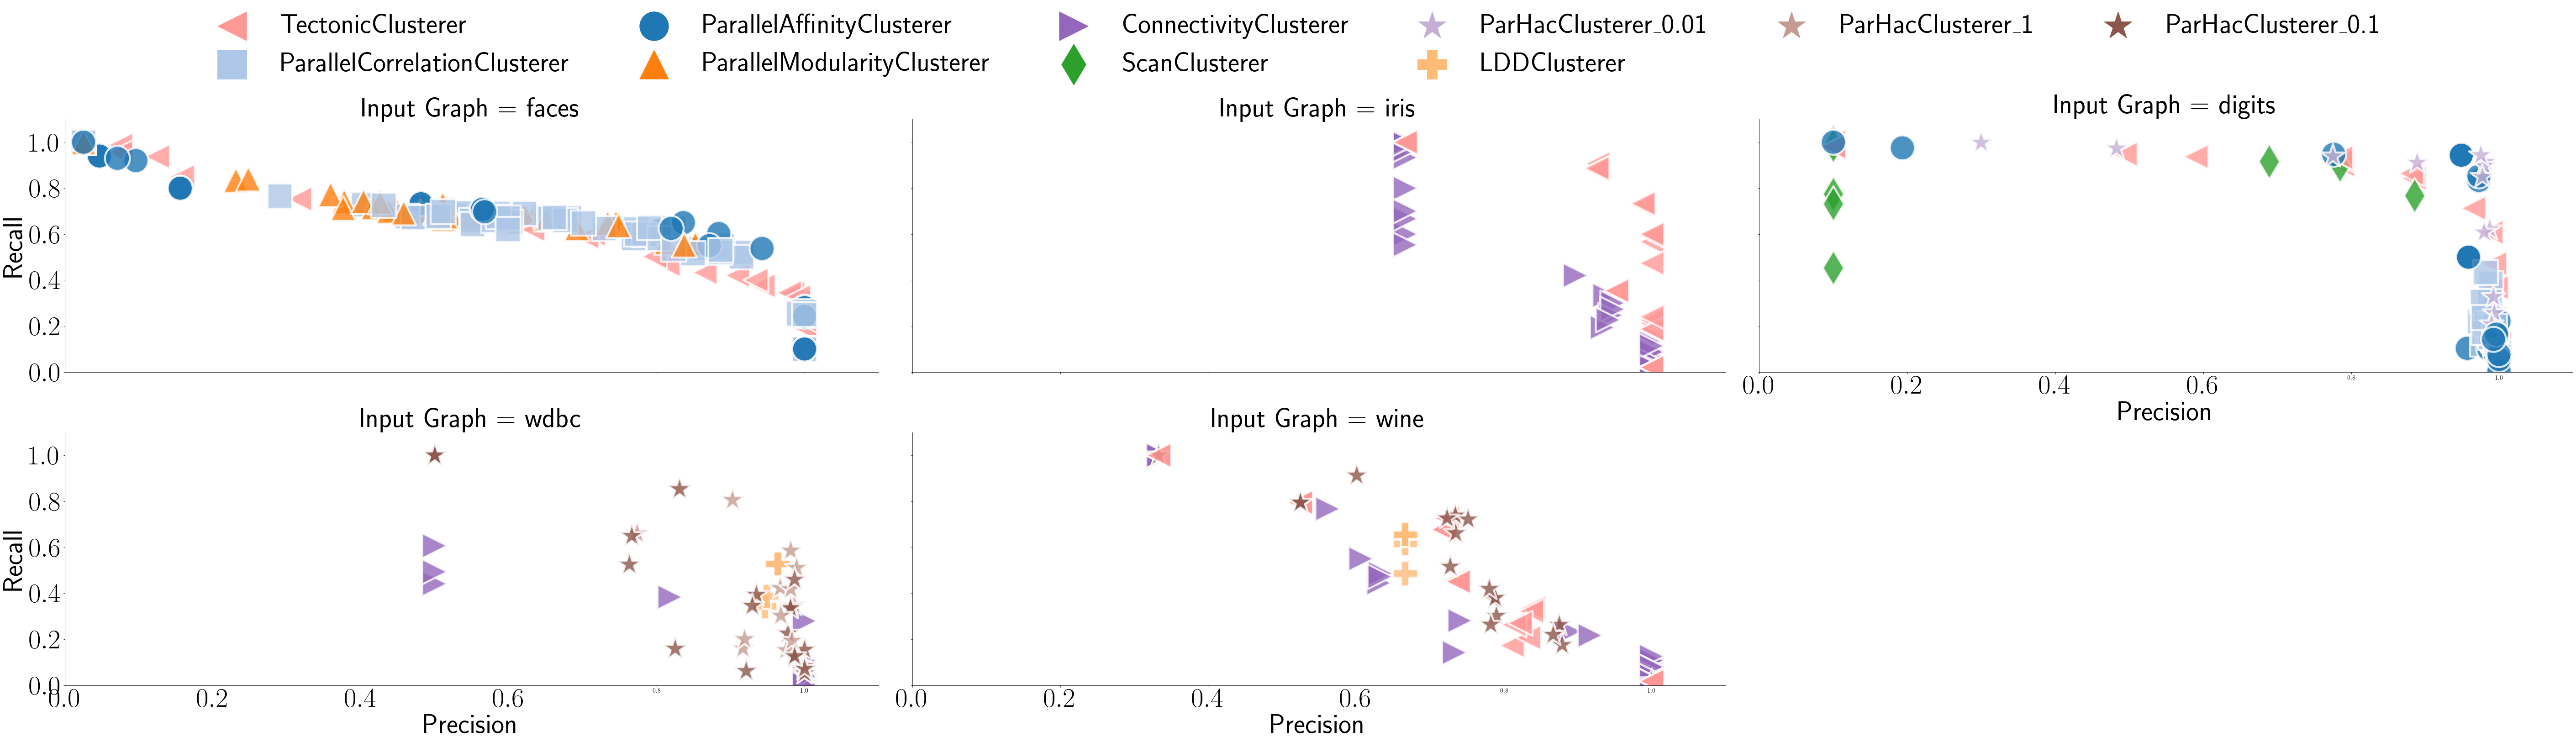

In [278]:
old_fontsize = fontsize
fontsize = 60
g = sns.FacetGrid(df, col="Input Graph", col_wrap=3, height = 10, aspect =0.4, xlim=(0, 1.1), ylim=(0,1.1)) # col_wrap decides the number of plots per row
g.map_dataframe(sns.scatterplot, x="communityPrecision_mean", y="communityRecall_mean", hue="Clusterer Name",
                s=3000, palette = color_map, style="Clusterer Name",  markers=style_map, alpha = 0.8)

g.set_titles(size=fontsize)  # Set title font size for FacetGrid plots
g.set_axis_labels("Precision", "Recall", fontsize=fontsize)  # Set

# Add a legend
get_larger_handles(g, 4000, 6)

set_face_grid_ax_ticks(g)
plt.tight_layout()
plt.savefig("../results/out_precision_recall_uci.pdf", bbox_inches='tight')
fontsize=old_fontsize

In [279]:
dfs, graphs = GetParetoDfs(df)

faces LDDClusterer
faces ScanClusterer
faces LabelPropagationClusterer
faces SLPAClusterer
faces ConnectivityClusterer
faces ParHacClusterer_0.01
faces ParHacClusterer_0.1
faces ParHacClusterer_1
iris ParallelAffinityClusterer
iris ParallelCorrelationClusterer
iris ParallelModularityClusterer
iris LDDClusterer
iris ScanClusterer
iris LabelPropagationClusterer
iris SLPAClusterer
iris ParHacClusterer_0.01
iris ParHacClusterer_0.1
iris ParHacClusterer_1
digits ParallelModularityClusterer
digits LDDClusterer
digits LabelPropagationClusterer
digits SLPAClusterer
digits ConnectivityClusterer
digits ParHacClusterer_0.1
digits ParHacClusterer_1
wdbc ParallelAffinityClusterer
wdbc ParallelCorrelationClusterer
wdbc ParallelModularityClusterer
wdbc ScanClusterer
wdbc LabelPropagationClusterer
wdbc SLPAClusterer
wdbc TectonicClusterer
wdbc ParHacClusterer_0.01
wine ParallelAffinityClusterer
wine ParallelCorrelationClusterer
wine ParallelModularityClusterer
wine ScanClusterer
wine LabelPropagationC

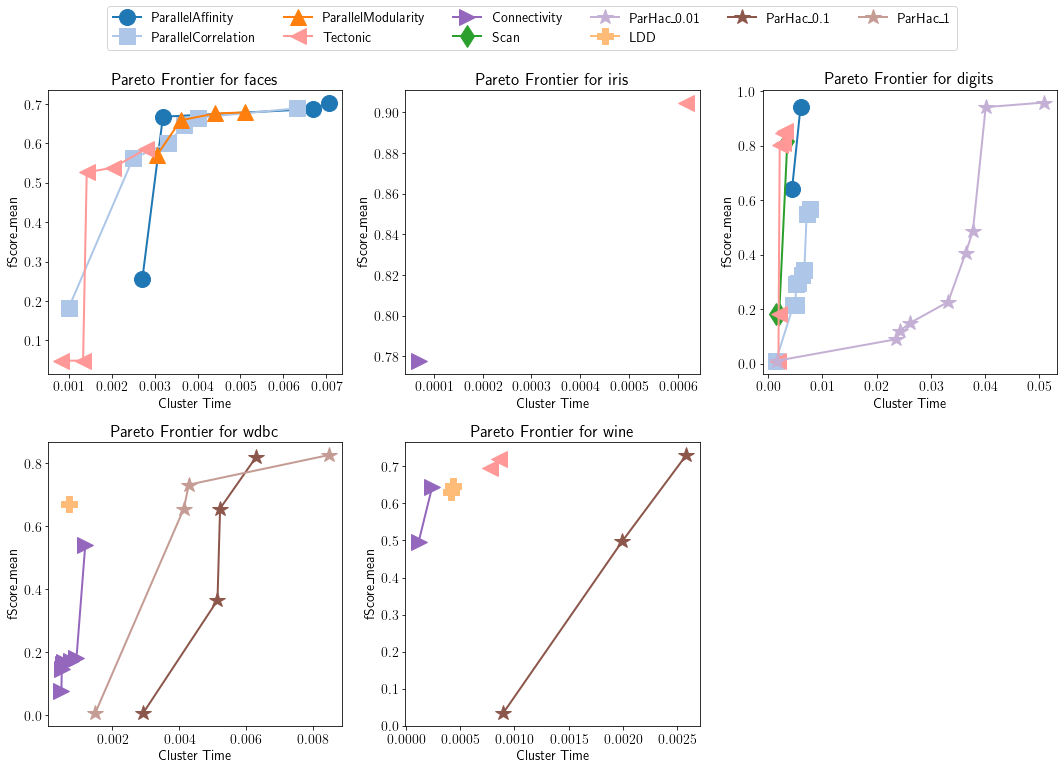

In [280]:

plt.rcParams.update({'font.size': 14})

# Create subplots in a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
graph_idx = 0

lines = []  # To store the Line2D objects for the legend
labels = []  # To store the corresponding labels for the Line2D objects

for i in range(2):
    for j in range(3):
        if graph_idx < len(graphs):  # Ensure we have a graph to process
            graph = graphs[graph_idx]
            ax = axes[i][j]

            for clusterer in clusterers:
                # Extract the pareto_df for the current graph and clusterer combination
                _, pareto_df = dfs[(graph, clusterer)]
                if pareto_df.empty:
                    print(graph, clusterer)
                    continue

                # Plot the pareto_df with the appropriate marker
                line, = ax.plot(pareto_df["Cluster Time"], pareto_df["fScore_mean"], label=clusterer, 
                                color=color_map[clusterer], marker=style_map[clusterer], markersize=16, linewidth=2)
                
                shortened_clusterer = clusterer.replace("Clusterer", "")
                # If the clusterer's line hasn't been added to lines, add it
                if shortened_clusterer not in labels:
                    lines.append(line)
                    labels.append(shortened_clusterer)

            ax.set_title(f"Pareto Frontier for {graph}")
            ax.set_xlabel("Cluster Time")
            ax.set_ylabel("fScore_mean")

            graph_idx += 1
        else:
            axes[i][j].axis('off')  # Turn off axes without data

    
# Create a single legend for the entire figure, at the top
fig.legend(lines, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.08))

plt.tight_layout()
plt.savefig("../results/out_time_f1_uci.pdf", bbox_inches='tight')


### Larger Weighted Graphs




In [282]:
df = pd.read_csv(base_addr + "weighted_results/stats_mnist.csv")
df_imagenet = pd.read_csv(base_addr + "weighted_results/stats_imagenet.csv")
df = pd.concat([df, df_imagenet])

df = df.dropna(how='all')
replace_graph_names(df)
df = add_epsilon_to_hac(df)
df = remove_small_f1_methods(df)
df = filterMethodsOnOverallPareto(df)

mnist_k10 0.9487557955569834
mnist_k50 0.908065031640817
imagenet_k10 0.8134036838917331
imagenet_k50 0.8246680886482192
imagenet_k100 0.8262418070991844


/var/folders/y9/y8cbtjy94z91vmk_p7zfqpyw0000gn/T/ipykernel_17766/1523129332.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Clusterer Name'] = df.apply(lambda row: f"{row['Clusterer Name']}_{extract_epsilon(row['Config'])}", axis=1)


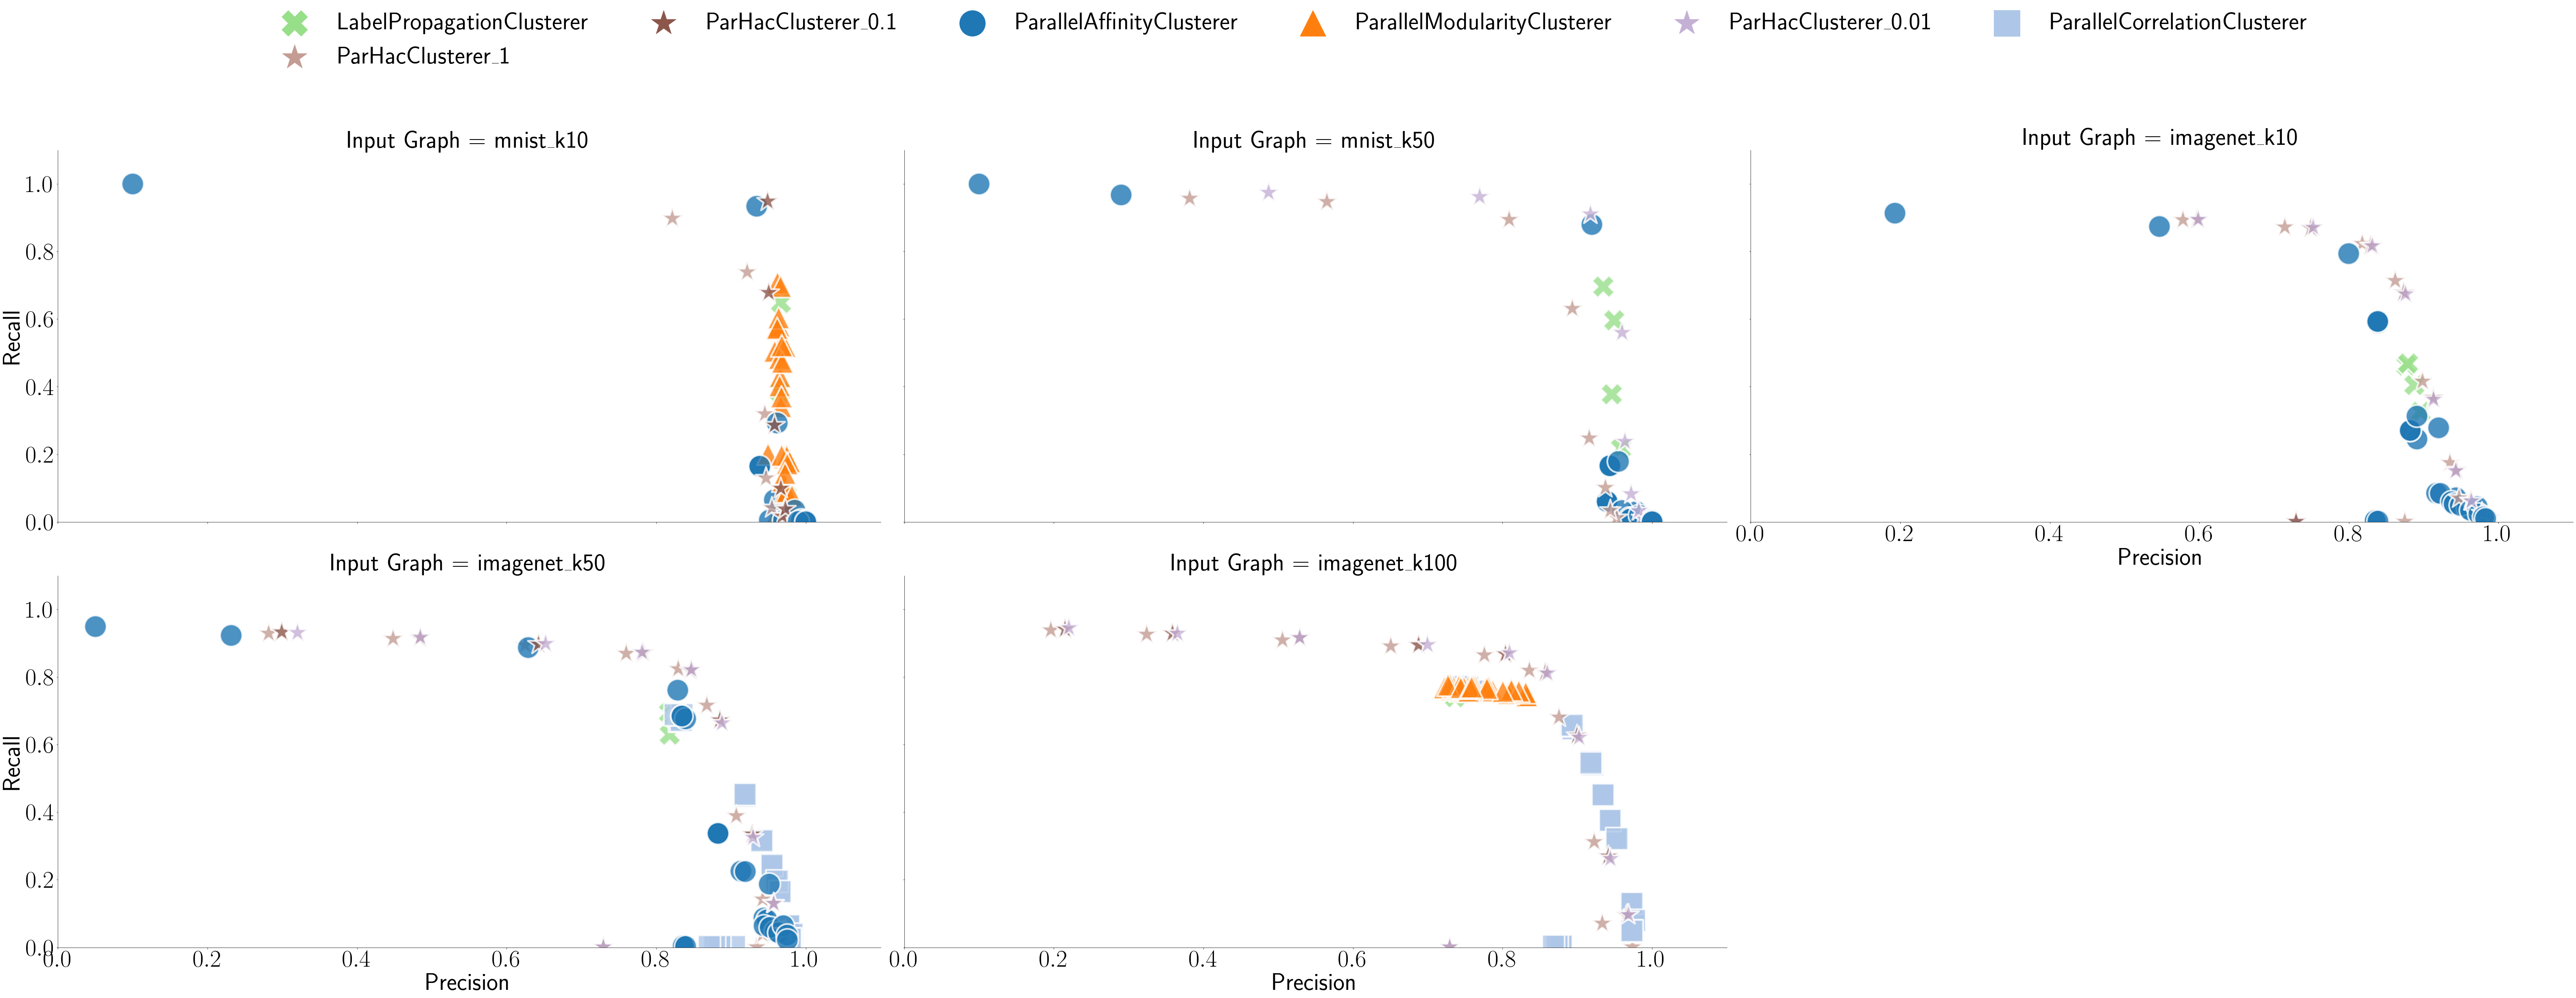

In [283]:
old_fontsize = fontsize
fontsize = 60
g = sns.FacetGrid(df, col="Input Graph", col_wrap=3, height = 15, aspect =0.4, xlim=(0, 1.1), ylim=(0,1.1)) # col_wrap decides the number of plots per row
g.map_dataframe(sns.scatterplot, x="communityPrecision_mean", y="communityRecall_mean", hue="Clusterer Name",
                s=3000, palette = color_map, style="Clusterer Name",  markers=style_map, alpha = 0.8)

g.set_titles(size=fontsize)  # Set title font size for FacetGrid plots
g.set_axis_labels("Precision", "Recall", fontsize=fontsize)  # Set

# Add a legend
get_larger_handles(g, 4000, 6)

set_face_grid_ax_ticks(g)
plt.tight_layout()
plt.savefig("../results/out_precision_recall_mnist.pdf", bbox_inches='tight')
fontsize=old_fontsize

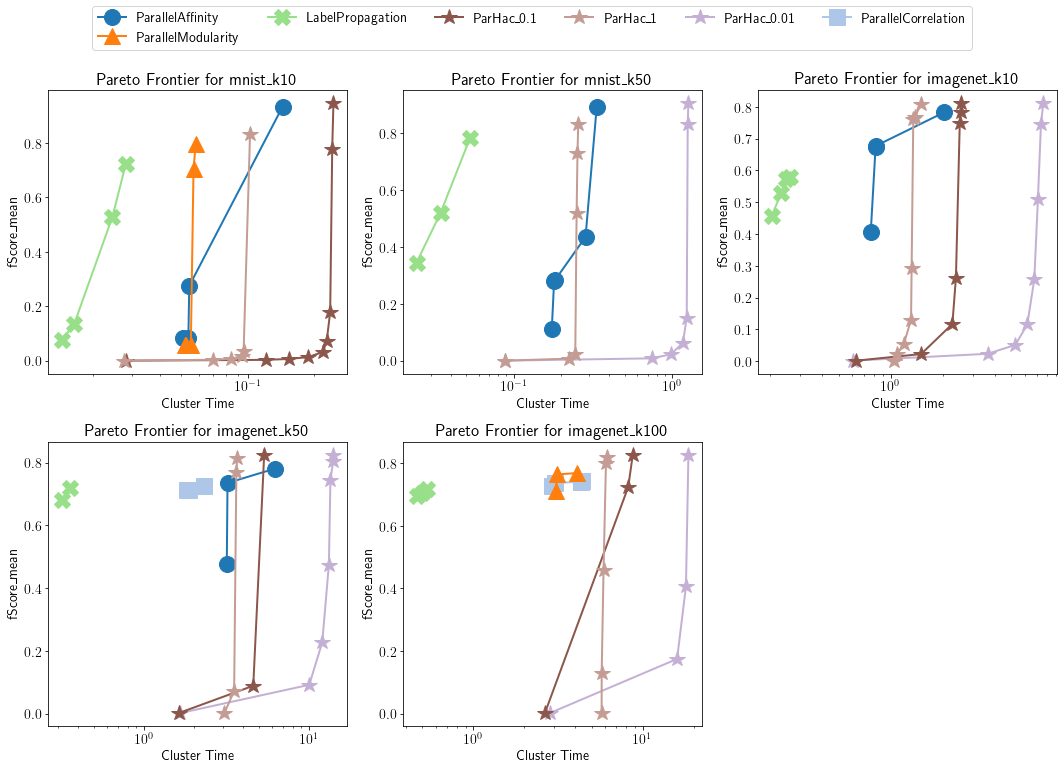

In [285]:
dfs, graphs = GetParetoDfs(df)
plt.rcParams.update({'font.size': 14})

# Create subplots in a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
graph_idx = 0

lines = []  # To store the Line2D objects for the legend
labels = []  # To store the corresponding labels for the Line2D objects

for i in range(2):
    for j in range(3):
        if graph_idx < len(graphs):  # Ensure we have a graph to process
            graph = graphs[graph_idx]
            ax = axes[i][j]

            for clusterer in clusterers:
                # Extract the pareto_df for the current graph and clusterer combination
                _, pareto_df = dfs[(graph, clusterer)]
                if pareto_df.empty:
#                     print(graph, clusterer)
                    continue

                # Plot the pareto_df with the appropriate marker
                line, = ax.plot(pareto_df["Cluster Time"], pareto_df["fScore_mean"], label=clusterer, 
                                color=color_map[clusterer], marker=style_map[clusterer], markersize=16, linewidth=2)
                
                shortened_clusterer = clusterer.replace("Clusterer", "")
                ax.set_xscale('log')
                # If the clusterer's line hasn't been added to lines, add it
                if shortened_clusterer not in labels:
                    lines.append(line)
                    labels.append(shortened_clusterer)

            ax.set_title(f"Pareto Frontier for {graph}")
            ax.set_xlabel("Cluster Time")
            ax.set_ylabel("fScore_mean")

            graph_idx += 1
        else:
            axes[i][j].axis('off')  # Turn off axes without data

    
# Create a single legend for the entire figure, at the top
fig.legend(lines, labels, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.08))

plt.tight_layout()
plt.savefig("../results/out_time_f1_mnist.pdf", bbox_inches='tight')


In [233]:
df_tmp = dfs[("mnist_k50", "ParHacClusterer")][0][["Clusterer Name", "Config","Cluster Time" ,"numberClusters", "fScore_mean", "communityPrecision_mean", "communityRecall_mean"]]
# print(df_tmp.to_csv())

KeyError: ('mnist_k50', 'ParHacClusterer')